In [1159]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import FunctionTransformer
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import warnings
warnings.filterwarnings("ignore")

In [1160]:
# Morphological traits 1 ~ 16
df = pd.read_csv('herb_data.csv')
df = df[df["Putative_spp"] != "Quercus sp."]
df = df[df["Putative_spp"] != "Quercus buckleyi"]
#df = df[df["Putative_spp"] != "Quercus shumardii"]
#df = df[df["Putative_spp"] != "Quercus shumardii var. acerifolia first, Quercus shumardii later"]
df["spp"] = df["Putative_spp"].apply(lambda x: "A" if x == "Quercus shumardii var. acerifolia" else "S or R")

data = df[["Lobe.number","BL","PL","BW","TLIW","TLL","TLDW","TEL","BLL","LLL","BSR","LSR","LLDW","LLIW","MidVeinD","BL_PL"]].dropna()

#store away a random row for testing
test_data = data.sample(1)
data = data.drop(test_data.index)

# Log-transform the data
transformer = FunctionTransformer(np.log, validate=True)
data_transformed = transformer.fit_transform(data)

# Standardize the data (important for PCA)
scaler = StandardScaler()
data_standardized = scaler.fit_transform(data_transformed)

In [1161]:
# Fit GMM with 2 components
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(data_standardized)
cluster_labels = gmm.predict(data_standardized)

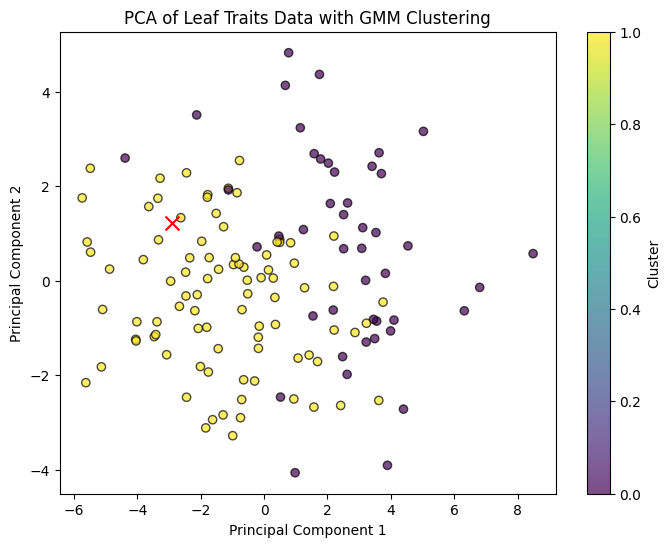

In [1162]:
# Perform PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_standardized)

# Plot the PCA-transformed data
plt.figure(figsize=(8, 6))
scatter = plt.scatter(data_pca[:, 0], data_pca[:, 1], c=cluster_labels, cmap='viridis', edgecolor='k', alpha=0.7)
#plot the test data
test_data_standardized = scaler.transform(transformer.transform(test_data))
test_data_pca = pca.transform(test_data_standardized)
plt.scatter(test_data_pca[:, 0], test_data_pca[:, 1], c='r', marker='x', s=100, label='Test Data')
plt.title('PCA of Leaf Traits Data with GMM Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster')
plt.show()

In [1163]:
#collect the data of group 1 as a set, and group 2 as another set
group1 = data[cluster_labels == 0]
group2 = data[cluster_labels == 1]
# assign the test datapoint to the most probable GMM cluster
test_point_cluster = gmm.predict(scaler.transform(transformer.transform(test_data)))[0]

In [1164]:
df["Longitude"] = df["Longitude"].abs()
loc_data = df[["Latitude", "Longitude","LLL.LLLDW","BL.BW"]].dropna()
#"LLL.LLLDW","BL.BW"

# Log-transform the data
transformer_2 = FunctionTransformer(np.log, validate=True)
loc_data_transformed = transformer_2.fit_transform(loc_data)
scaler_2 = StandardScaler()
loc_data_standardized = scaler_2.fit_transform(loc_data_transformed)

In [1165]:
# from sklearn.cluster import KMeans
# kmeans = KMeans(n_clusters=2, random_state=0)
# kmeans.fit(loc_data_standardized)
# loc_cluster_labels = kmeans.predict(loc_data_standardized)

loc_gmm = GaussianMixture(n_components=2, random_state=0)
loc_gmm.fit(loc_data_standardized)
loc_cluster_labels = loc_gmm.predict(loc_data_standardized)

In [1166]:
#collect the data of group 1 as a set, and group 2 as another set
loc_group_a = loc_data[loc_cluster_labels == 0]
loc_group_b= loc_data[loc_cluster_labels == 1]
#generate group centroids
loc_group_a_centroid = loc_group_a.mean()
loc_group_b_centroid = loc_group_b.mean()
#compare size of group 1 and group 2
loc_group_a_size = len(loc_group_a)
loc_group_b_size = len(loc_group_b)
print("loc_group A (Purple) size: ", loc_group_a_size)
print("loc_group B (Yellow) size: ", loc_group_b_size)
# assign the test datapoint to the most probable GMM cluster
test_data_ground_truth = loc_data.loc[test_data.index]
distance_from_group_a = np.linalg.norm(test_data_ground_truth - loc_group_a_centroid)
distance_from_group_b = np.linalg.norm(test_data_ground_truth - loc_group_b_centroid)
print("Distance from group A (Purple) centroid: ", distance_from_group_a)
print("Distance from group B (Yellow) centroid: ", distance_from_group_b)

loc_group A (Purple) size:  87
loc_group B (Yellow) size:  48
Distance from group A (Purple) centroid:  0.7595667462958
Distance from group B (Yellow) centroid:  1.3643381350526784


Text(0, 0.5, 'Longitude')

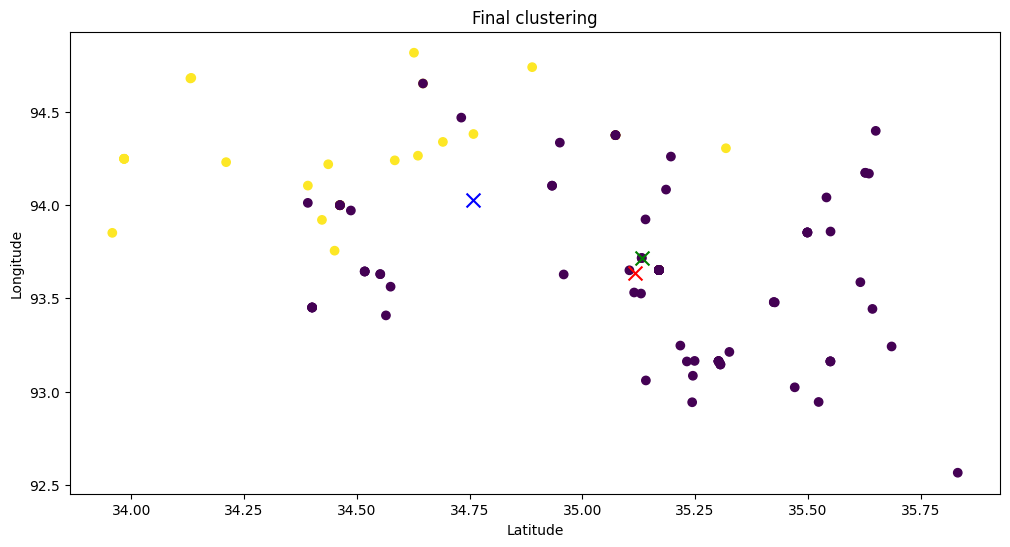

In [1167]:
#visualize the data
plt.figure(figsize=(12, 6))
plt.scatter(loc_data["Latitude"], loc_data["Longitude"], c=loc_cluster_labels, cmap='viridis')
plt.scatter(loc_group_a_centroid[0], loc_group_a_centroid[1], c='red', s=100, marker='x')
plt.scatter(loc_group_b_centroid[0], loc_group_b_centroid[1], c='blue', s=100, marker='x')
plt.scatter(test_data_ground_truth["Latitude"], test_data_ground_truth["Longitude"], c='green', s=100, marker='x')
plt.title("Final clustering")
plt.xlabel("Latitude")
plt.ylabel("Longitude")

In [1209]:

decision_matrix = np.zeros((2, 2))
for i in range(135):
    supervised_pt = df.sample(1)
    #keep only 16 columns of supervised data
    gmm_pt = supervised_pt[["Lobe.number","BL","PL","BW","TLIW","TLL","TLDW","TEL","BLL","LLL","BSR","LSR","LLDW","LLIW","MidVeinD","BL_PL"]].dropna()
    kmeans_pt = supervised_pt[["Latitude", "Longitude","LLL.LLLDW","BL.BW"]].dropna()
    pred1 = gmm.predict(scaler.transform(transformer.transform(gmm_pt)))
    pred2 = loc_gmm.predict(scaler_2.transform(transformer_2.transform(kmeans_pt)))
    decision_matrix[pred1[0]][pred2[0]] += 1

#print("Decision matrix: ")
#print(decision_matrix)

decision_vector = np.argmax(decision_matrix, axis=1)
#if the decision vector does not sum up to 1, generate a random vector that contains 0 and 1
if sum(decision_vector) == 0:
    decision_vector[np.random.randint(2)] = 1
elif sum(decision_vector) == 2:
    decision_vector[np.random.randint(2)] = 0
#print("Decision vector: ", decision_vector)
        

In [1169]:
decision_vector = np.array([1, 0])
predict_group = 0

test_result = decision_vector[test_point_cluster]
if test_result == 0:
    print("Test point is in group A (Purple)")
else:
    print("Test point is in group B (Yellow)")
    predict_group = 1

distance_from_group_a = np.linalg.norm(test_data_ground_truth - loc_group_a_centroid)
distance_from_group_b = np.linalg.norm(test_data_ground_truth - loc_group_b_centroid)
actual_closer_group = np.argmin([distance_from_group_a, distance_from_group_b])
print("Distance from group A (Purple) centroid: ", distance_from_group_a)
print("Distance from group B (Yellow) centroid: ", distance_from_group_b)
if predict_group == actual_closer_group:
    print("Close prediction!")
else:
    print("Far prediction!")

Test point is in group A (Purple)
Distance from group A (Purple) centroid:  0.7595667462958
Distance from group B (Yellow) centroid:  1.3643381350526784
Close prediction!
